In [0]:
pwd

'/content'

In [0]:
from google.colab import drive
drive.mount('./drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./drive


In [0]:
!ls './drive/My Drive/Thesis Work'

 CambridgeMonoPhoneDf.pickle	      Implementation3.ipynb
 CambridgeWordFeaturesDf.pickle       Implementation4
 CheckScrapSpeed.ipynb		      Implementation4.ipynb
 ConvertToWav.ipynb		      L2monoPhoneDfTest.pickle
'Copy of l2arctic_release_v2.0.zip'   L2monoPhoneDfTrain.pickle
 DelIfCopiesFine.ipynb		      L2WordFeaturesDfTest.pickle
 Implementation1		      L2WordFeaturesDfTrain.pickle
 Implementation1.ipynb		      MostCommon3000Oxford.txt
 Implementation2		      UKpronunciations
 Implementation2.ipynb		      USpronunciations
 Implementation3


Bism  
# Imports

In [3]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
from tqdm import tqdm_notebook


#SKLEARN
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as sklm
from sklearn.manifold import TSNE

#KERAS
from keras import models
from keras.models import Model, load_model
from keras import callbacks
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


# Implementation 4  (PHONE LEVEL)
## Using L2Training set
## L2 as val+test set

### Training

#### X_TRAIN

In [0]:
train_featureDf = pd.read_pickle("./drive/My Drive/Thesis Work/L2monoPhoneDfTrain.pickle")
train_featureDf['deltaC'] = train_featureDf.MFCCs.apply(librosa.feature.delta)
train_featureDf['doubleDeltaC'] = train_featureDf.MFCCs.apply(librosa.feature.delta, order=2)

In [0]:
train_featureDf.head()

phones  n_frames  labels errorType  \
0    sil     25578       1         c   
1      F     25578       1         c   
2    AO1     25578       1         c   
3      R     25578       1         c   
4     sp     25578       1         c   

                                               MFCCs  \
0  [[-500.87595880043995, -490.530093482248, -478...   
1  [[-482.8573339648256, -459.1598097501334, -427...   
2  [[-252.77778931377523, -262.81390243815207, -2...   
3  [[-252.70229310044942, -258.73414781929034, -2...   
4  [[-313.843311015891, -318.4961836619211, -340....   

                                              deltaC  \
0  [[-69.98737970456988, -69.98737970456988, -69....   
1  [[22.491430337093377, 22.491430337093377, 22.4...   
2  [[6.331442686555222, 6.331442686555222, 6.3314...   
3  [[-12.007007345214117, -12.007007345214117, -1...   
4  [[-57.932107548045735, -57.932107548045735, -5...   

                                        doubleDeltaC  
0  [[-1.613880905065896, -1.613880905065896, -1.6...  
1  [[-5.736006768697174, -5.736006768697174, -5.7...  
2  [[1.9718040800135672, 1.9718040800135672, 1.97...  
3  [[-11.204162208124938, -11.204162208124938, -1...  
4  [[-32.0553397555799, -32.0553397555799, -32.05...

In [0]:
print("Train Phones: ", len(train_featureDf.phones))
print("Unique Train Phones: ", len(set(train_featureDf.phones)))

Train Phones:  74316
Unique Train Phones:  80


In [0]:
#remove stresses
train_featureDf.phones = [''.join([alpha for alpha in phone if alpha.isalpha()]) for phone in train_featureDf.phones]

In [0]:
print("Unique Train Phones: ", len(set(train_featureDf.phones)))

Unique Train Phones:  42


In [0]:
train_featureDf.head()

phones  n_frames  labels errorType  \
0    sil     25578       1         c   
1      F     25578       1         c   
2     AO     25578       1         c   
3      R     25578       1         c   
4     sp     25578       1         c   

                                               MFCCs  \
0  [[-500.87595880043995, -490.530093482248, -478...   
1  [[-482.8573339648256, -459.1598097501334, -427...   
2  [[-252.77778931377523, -262.81390243815207, -2...   
3  [[-252.70229310044942, -258.73414781929034, -2...   
4  [[-313.843311015891, -318.4961836619211, -340....   

                                              deltaC  \
0  [[-69.98737970456988, -69.98737970456988, -69....   
1  [[22.491430337093377, 22.491430337093377, 22.4...   
2  [[6.331442686555222, 6.331442686555222, 6.3314...   
3  [[-12.007007345214117, -12.007007345214117, -1...   
4  [[-57.932107548045735, -57.932107548045735, -5...   

                                        doubleDeltaC  
0  [[-1.613880905065896, -1.613880905065896, -1.6...  
1  [[-5.736006768697174, -5.736006768697174, -5.7...  
2  [[1.9718040800135672, 1.9718040800135672, 1.97...  
3  [[-11.204162208124938, -11.204162208124938, -1...  
4  [[-32.0553397555799, -32.0553397555799, -32.05...

In [0]:
val_featureDf = train_featureDf[train_featureDf['labels'] == 0] #Use Only correct ones for training rest discard
train_featureDf = train_featureDf[train_featureDf['labels'] == 1]

In [0]:
len(train_featureDf.phones)

65113

In [0]:
train_featureDf.phones.nunique() #42 phones

42

In [0]:
x_train = np.array((train_featureDf.MFCCs,train_featureDf.deltaC,train_featureDf.doubleDeltaC))
x_train.shape

(3, 65113, 13, 50)

In [0]:
x_train = np.transpose(x_train,[1,2,3,0])
x_train.shape

(65113, 13, 50, 3)

In [0]:
np.save('./drive/My Drive/Thesis Work/Implementation4/x_train.npy',x_train) #Feature vector

_______

#### Y_TRAIN

In [0]:
train_phones = np.array(train_featureDf.phones)
np.save('./drive/My Drive/Thesis Work/Implementation4/train_phones.npy', train_phones)

In [0]:
encoder = LabelBinarizer()
y_train = encoder.fit_transform(train_phones)
y_train.shape

(65113, 42)

In [0]:
np.save('./drive/My Drive/Thesis Work/Implementation4/y_train.npy',y_train) #save y_train

#### MODEL

In [0]:
x_train = np.load("./drive/My Drive/Thesis Work/Implementation4/x_train.npy")
y_train = np.load("./drive/My Drive/Thesis Work/Implementation4/y_train.npy")

In [0]:
model = Sequential()

model.add(Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=(13, 50, 3)))
model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(42, activation='softmax'))

model.load_weights("./drive/My Drive/Thesis Work/Implementation3/model.h5")
callbacklist=[callbacks.History(),callbacks.ModelCheckpoint('./jawadmodel.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=5)]
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=25000, epochs=500, callbacks=callbacklist)

In [0]:
model = load_model('./drive/My Drive/Thesis Work/Implementation4/model.h5')
callbacklist=[callbacks.History(),callbacks.ModelCheckpoint('./jawadmodel.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=5)]
model.fit(x_train, y_train, batch_size=25000, epochs=500, callbacks=callbacklist)

Epoch 1/500
65113/65113 [==============================] - 24s 362us/step - loss: 0.3914 - acc: 0.8858
Epoch 2/500
65113/65113 [==============================] - 10s 147us/step - loss: 0.3933 - acc: 0.8845
Epoch 3/500
65113/65113 [==============================] - 10s 147us/step - loss: 0.3957 - acc: 0.8840
Epoch 4/500
65113/65113 [==============================] - 10s 147us/step - loss: 0.3956 - acc: 0.8832
Epoch 5/500
65113/65113 [==============================] - 10s 146us/step - loss: 0.3988 - acc: 0.8829

Epoch 00005: loss improved from inf to 0.39883, saving model to ./jawadmodel.h5
Epoch 6/500
65113/65113 [==============================] - 10s 147us/step - loss: 0.3965 - acc: 0.8833
Epoch 7/500
65113/65113 [==============================] - 10s 148us/step - loss: 0.3908 - acc: 0.8858
Epoch 8/500
65113/65113 [==============================] - 10s 147us/step - loss: 0.3943 - acc: 0.8848
Epoch 9/500
65113/65113 [==============================] - 10s 147us/step - loss: 0.3887 - acc:

AH

In [0]:
!cp ./jawadmodel.h5 "./drive/My Drive/Thesis Work/Implementation4/model.h5"

In [0]:
!ls "./drive/My Drive/Thesis Work/Implementation4/"

model.h5	 test_phones.npy       train_phones.npy  x_train.npy
test_labels.npy  test_typeOfError.npy  x_test.npy	 y_train.npy


### TESTING

#### Representation Layer, L2 norm, Prediction Checks

In [0]:
!ls './drive/My Drive/Thesis Work/Implementation4'

model.h5	 test_phones.npy       train_phones.npy  x_train.npy
test_labels.npy  test_typeOfError.npy  x_test.npy	 y_train.npy


loss: 0.0055 - acc: 100% ==> Trained Model (Cambrige Phones)

In [0]:
train_phones = np.load("./drive/My Drive/Thesis Work/Implementation4/train_phones.npy") #vocabulary

In [0]:
encoder = LabelBinarizer()
encoder.fit(train_phones)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [0]:
encoder.inverse_transform(model.predict(x_train[:4])) #predicting correctly

array(['sil', 'F', 'AO', 'R'], dtype='<U3')

In [0]:
encoder.inverse_transform(y_train[:4])

array(['sil', 'F', 'AO', 'R'], dtype='<U3')

In [0]:
np.all(encoder.inverse_transform(y_train) == train_phones) #decoder also working fine

True

In [0]:
model.layers[-2] #representation

In [0]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=-2).output)

In [0]:
np.linalg.norm(intermediate_layer_model.predict(x_train[1:2]) - intermediate_layer_model.predict(x_train[1:2])) #l2 norm

0.0

In [0]:
intermediate_layer_model.predict(x_train[0:1]).shape

(1, 50)

#### LOADING ARRAYS, VALIDATION AND TESTING

In [1]:
!ls './drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/'

autoencoderModelALL.h5	test_labels.npy       train_phones.npy	y_train.npy
model.h5		test_phones.npy       x_test.npy
phone_means		test_typeOfError.npy  x_train.npy


In [4]:
x_train = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/x_train.npy')
train_phones = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/train_phones.npy')
y_train = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/y_train.npy')


model = load_model('./drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/model.h5')
encoder = LabelBinarizer()
encoder.fit(train_phones)
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=-2).output)


x_test = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/x_test.npy')
test_labels = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/test_labels.npy')
test_phones = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/test_phones.npy')
test_typeOfError = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL-CAE_MFCC_TrainL2_TestL2/test_typeOfError.npy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
#For balancing data undersample +ve
'''x_test = np.vstack((x_test[test_labels == 1][:sum(test_labels == 0)],x_test[test_labels == 0])) #have to permute this also
test_labels = np.vstack((test_labels[test_labels == 1][:sum(test_labels == 0)],test_labels[test_labels == 0])) #have to permute this also
test_labels = test_labels.reshape(-1)
shuffledIndexes = np.random.permutation(range(x_test.shape[0]))
x_test = x_test[shuffledIndexes]
test_labels = test_labels[shuffledIndexes]
x_test.shape'''

(8076, 13, 50, 3)

In [5]:
x_test.shape

(34799, 13, 50, 3)

In [6]:
train_phones.shape #l2

(65113,)

In [7]:
test_phones.shape #l2

(34799,)

In [8]:
train_representations = intermediate_layer_model.predict(x_train)
train_representations.shape

(65113, 50)

In [9]:
[p for p in test_phones if p not in train_phones] #AX and spn not present

['spn', 'spn', 'AX', 'spn']

In [12]:
#VALIDATION

valSetLength = 15000 #initial some from test

truelabels = [test_labels[i] for i in range(valSetLength) if test_phones[i] in train_phones]

accs = []
f1mis = []
for threshold in [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105]:
  predictedLabels = []
  for i in range(valSetLength): #iterating on test phones
    if test_phones[i] in train_phones:
      '''print(i)
      print(test_phones[i])
      print(test_labels[i])
      print(np.mean(np.linalg.norm(train_representations[np.argwhere(train_phones == test_phones[i]).reshape(-1,)]\
                       - intermediate_layer_model.predict(x_test[i:i+1]),axis=1)))'''
      if np.mean(np.linalg.norm(train_representations[np.argwhere(train_phones == test_phones[i]).reshape(-1,)]\
                       - intermediate_layer_model.predict(x_test[i:i+1]),axis=1)) <= threshold:
        predictedLabels.append(1)
      else: 
        predictedLabels.append(0)

  accs.append(sklm.accuracy_score(truelabels,predictedLabels))
  f1mis.append(sklm.precision_recall_fscore_support(truelabels,predictedLabels)[2][0])

print("Threshold: ", np.argmax(f1mis))
print("Max Achievable Accuracy: ", accs[np.argmax(f1mis)])
print("Max Achievable F-1 score for Mispronunciations: ", max(f1mis))
print('\n ------------------- \n')
print("Max Achievable Accuracy (Overall): ", max(accs))
print("Max Achievable Accuracy (Overall) on Threshold: ", np.argmax(accs))

print("Max Achievable F-1 score Threshold: ", np.argmax(f1mis))
print("Max Achievable Accuracy On This Threshold: ", accs[np.argmax(f1mis)])
print("Max Achievable F-1 score for Mispronunciations: ", max(f1mis))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold:  7
Max Achievable Accuracy:  0.2363490899393293
Max Achievable F-1 score for Mispronunciations:  0.24165783898305085

 ------------------- 

Max Achievable Accuracy (Overall):  0.8213214214280952
Max Achievable Accuracy (Overall) on Threshold:  19
Max Achievable F-1 score Threshold:  7
Max Achievable Accuracy On This Threshold:  0.2363490899393293
Max Achievable F-1 score for Mispronunciations:  0.24165783898305085


In [0]:
#TESTING

valSetLength = 15000 #initial some from test
threshold = 45
truelabels = [test_labels[i] for i in range(valSetLength,test_labels.shape[0]) if test_phones[i] in train_phones]

predictedLabels = []
for i in range(valSetLength,test_labels.shape[0]): #iterating on test words
  if test_phones[i] in train_phones:
    '''print(i)
    print(test_phones[i])
    print(test_labels[i])
    print(np.mean(np.linalg.norm(train_representations[np.argwhere(train_phones == test_phones[i]).reshape(-1,)]\
                     - intermediate_layer_model.predict(x_test[i:i+1]),axis=1)))'''
    if np.mean(np.linalg.norm(train_representations[np.argwhere(train_phones == test_phones[i]).reshape(-1,)]\
                     - intermediate_layer_model.predict(x_test[i:i+1]),axis=1)) <= threshold:
      predictedLabels.append(1)
    else: 
      predictedLabels.append(0)

In [14]:
print('Accuracy = ', sklm.accuracy_score(truelabels,predictedLabels))
sklm.precision_recall_fscore_support(truelabels,predictedLabels) #0 - 1

Accuracy =  0.23186502323701758


(array([0.10894734, 0.93294954]),
 array([0.90260698, 0.15509767]),
 array([0.19442679, 0.26597799]),
 array([ 2033, 17763]))

In [15]:
print(sklm.classification_report(truelabels, predictedLabels, target_names=['Mispronounced','Correct']))
print(sklm.confusion_matrix(truelabels, predictedLabels, labels=range(2)))

print(sklm.roc_curve(truelabels,predictedLabels))
print('FAR = ', sklm.roc_curve(truelabels,predictedLabels)[0][1]*100,'%')
print('FRR = ', (1 - sklm.roc_curve(truelabels,predictedLabels)[1][1])*100,'%')
print("AUC_SCORE = ", sklm.roc_auc_score(truelabels,predictedLabels)*100,'%')

               precision    recall  f1-score   support

Mispronounced       0.11      0.90      0.19      2033
      Correct       0.93      0.16      0.27     17763

    micro avg       0.23      0.23      0.23     19796
    macro avg       0.52      0.53      0.23     19796
 weighted avg       0.85      0.23      0.26     19796

[[ 1835   198]
 [15008  2755]]
(array([0.        , 0.09739302, 1.        ]), array([0.        , 0.15509767, 1.        ]), array([2, 1, 0]))
FAR =  9.739301524840139 %
FRR =  84.49023250577042 %
AUC_SCORE =  52.88523298469472 %


### Results

*CANNOT COMPARE RESULTS:*  
The Interspeech one has a **different dataset** and shows results on phone level (as every phone is a separate class there)

The l2-arctic one shows no results

I am the first one to show results on this dataset

**Results are not quite good. Have to visualize what in the world is going on**

In [0]:
train_representations2D = TSNE(n_components=2).fit_transform(train_representations)
train_representations2D.shape

(20794, 2)

In [0]:
test_representations = intermediate_layer_model.predict(x_test)
test_representations2D = TSNE(n_components=2).fit_transform(test_representations)
test_representations2D.shape

(34799, 2)

In [0]:
np.save("./drive/My Drive/Thesis Work/Implementation3/test_representations2D.npy",test_representations2D)

In [0]:
train_representations2D = np.load("./drive/My Drive/Thesis Work/Implementation3/train_representations2D.npy")

In [0]:
print(set(test_phones))

{'D', 'JH', 'Z', 'OW', 'N', 'UW', 'IY', 'SH', 'AW', 'EH', 'R', 'AY', 'B', 'HH', 'K', 'OY', 'Y', 'P', 'spn', 'DH', 'EY', 'TH', 'L', 'F', 'UH', 'IH', 'T', 'S', 'AO', 'AX', 'ER', 'V', 'G', 'AA', 'AH', 'W', 'CH', 'sil', 'M', 'AE', 'sp', 'NG'}


In [0]:
def scatterPlot(phone):
  plt.figure(figsize=(8,6))
  plt.title("Plot For Phone --> "+phone)
  mask = train_phones == phone
  plt.scatter(train_representations2D[mask,0],train_representations2D[mask,1], label = 'Train', c ='g')
  mask = (test_phones == phone) & (test_labels == 1)
  plt.scatter(test_representations2D[mask,0],test_representations2D[mask,1], label = 'Correct', c = 'b',marker='+')
  mask = (test_phones == phone) & (test_labels == 0)
  plt.scatter(test_representations2D[mask,0],test_representations2D[mask,1], label = 'Incorrect' ,c = 'r', marker='x')
  plt.legend()

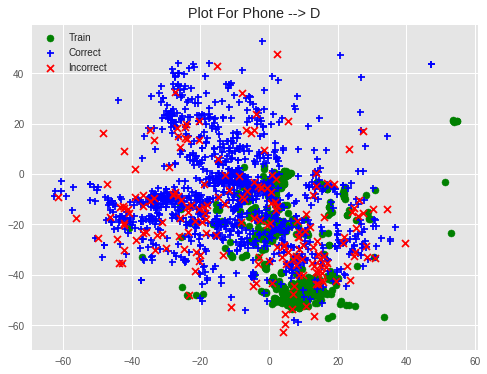

In [0]:
scatterPlot('D')

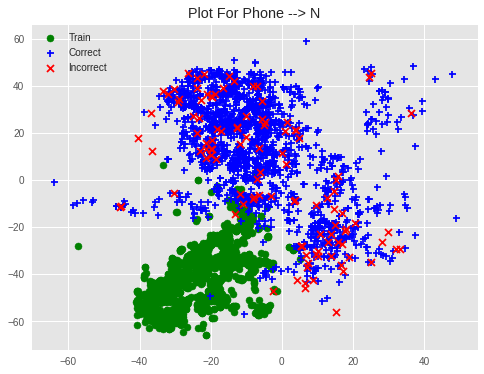

In [0]:
scatterPlot('N')

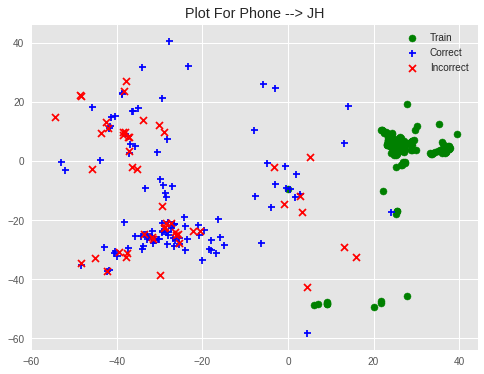

In [0]:
scatterPlot('JH')